# QGANs Implementation for Stock Price Prediction

In this codebook, I have implemented the Quantum Generative Adversarial Networks from chapter 4 of the book Financial Modeling Using Quantum Computing. The link for the same is mentioned below. The code is not copied as it is, but modified as per my requirements. The function discretize_and_truncate is written by me completely from scratch since the original function mentioned in the book is no longer continued by Qiskit. 

Book link: https://www.oreilly.com/library/view/financial-modeling-using/9781804618424/

In [1]:
# !pip install openchart
# !pip install custatevec_cu12
# !pip install pennylane-lightning-gpu
# !pip install torch
# !pip install pandas
# !pip install numpy
# !pip install matplotlib

In [4]:
from openchart import NSEData
import pandas as pd
import numpy as np
import datetime
import warnings

warnings.filterwarnings('ignore')

In [5]:
nse=NSEData()

# Get the NSE meta data
nse.download()

NSE data shape: (3161, 4)
NFO data shape: (87662, 4)
NSE and NFO data downloaded successfully.


In [6]:
end_date=datetime.datetime.now()
start_date=end_date - datetime.timedelta(days=365)

# Get historical data for a specific stock
data=nse.historical(
    symbol='RELIANCE',
    start=start_date,
    end=end_date,
    interval='1m',
    exchange='NSE'
)

data.columns=data.columns.str.lower()

In [7]:
print(data.head())

                       open    high     low   close  volume
Timestamp                                                  
2025-10-15 09:15:59  1378.6  1384.0  1378.6  1382.0  167634
2025-10-15 09:16:35  1381.8  1381.8  1379.1  1379.1   61653
2025-10-15 09:17:59  1379.7  1381.0  1379.3  1380.7  144518
2025-10-15 09:18:59  1381.0  1381.0  1378.3  1379.7   66257
2025-10-15 09:19:59  1379.7  1379.7  1378.7  1379.0   42491


In [8]:
training_data=data[['close']]
# training_data=training_data[0:300]
training_data=training_data.to_numpy()

data_dim=3

bounds=[]

# bounds_min=np.percentile(training_data, 5, axis=0)
# bounds_max=np.percentile(training_data, 95, axis=0)
bounds_min=min(training_data)
bounds_max=max(training_data)

bounds.append(float(bounds_min[0]))
bounds.append(float(bounds_max[0]))

In [9]:
print(bounds)

[1373.2, 1524.4]


In [10]:
def discretize_and_truncate(training_data,bounds,data_dim):
    # Calculating the bin range
    bin_range=float((bounds[1]-bounds[0])/data_dim)

    # Preparing the bin indices as a list called grid_data
    grid_data=[]
    for i in range(data_dim):
        grid_data.append(i)

    # Preparing the bin ranges for each of the buckets
    bin_ranges=[]
    range_begin=bounds[0]

    for _ in range(data_dim):
        range_end=float(range_begin+bin_range)
        bin_ranges.append([range_begin,range_end])
        range_begin=range_end

    # Getting bin centers as a list called grid_elements
    grid_elements=[]
    center=float(bin_range/2)

    for i in range(data_dim):
        grid_elements.append(float(bin_ranges[i][0]+center))

    # Creating a new set of discretized training data as per bin mapping and the probability of each bin
    new_training_data=[]
    prob_data=[]

    for i in range(data_dim):
        prob_data.append(0)

    for i in range(len(training_data)):
        for j in range(len(bin_ranges)):
            if(training_data[i]>=bin_ranges[j][0] and training_data[i]<bin_ranges[j][1]):
                new_training_data.append(j)
                prob_data[j]+=1

    for i in range(data_dim):
        prob_data[i]=float(prob_data[i]/len(training_data))

    return new_training_data, grid_data, grid_elements, prob_data

In [11]:
training_data, grid_data, grid_elements, prob_data = discretize_and_truncate(training_data,bounds,data_dim)

print('training_data: ',training_data[0:10])
print('grid_data: ',grid_data)
print('grid_elements: ',grid_elements)
print('prob_data: ',prob_data)
print('\n')

zero=0
one=0
two=0

for i in range(len(training_data)):
  if(training_data[i]==0):
    zero+=1
  elif(training_data[i]==1):
    one+=1
  else:
    two+=1

print('Bucket wise data count: ')
print('Bucket 0: ',zero)
print('Bucket 1: ',one)
print('Bucket 2: ',two)

training_data:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
grid_data:  [0, 1, 2]
grid_elements:  [1398.4, 1448.8000000000002, 1499.2000000000003]
prob_data:  [0.15632823365785814, 0.164673157162726, 0.6789986091794159]


Bucket wise data count: 
Bucket 0:  1124
Bucket 1:  1184
Bucket 2:  4882


Text(0, 0.5, 'count')

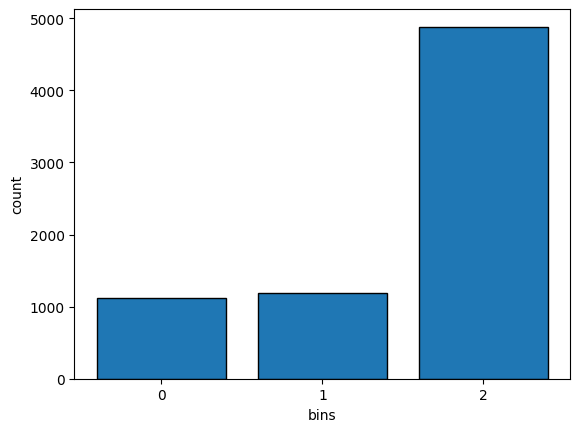

In [12]:
import matplotlib.pyplot as plt

plt.hist(training_data, bins=[0,1,2,3], edgecolor='black',align='left',rwidth=0.8)
plt.xticks(grid_data)
plt.xlabel('bins')
plt.ylabel('count')

[1.413033401227318, 2.260944585038659, 1.9395437695420534, 1.3568230124076248, 1.7099927889102615, 2.0352427732583647]
(<Figure size 900x400 with 1 Axes>, <Axes: >)


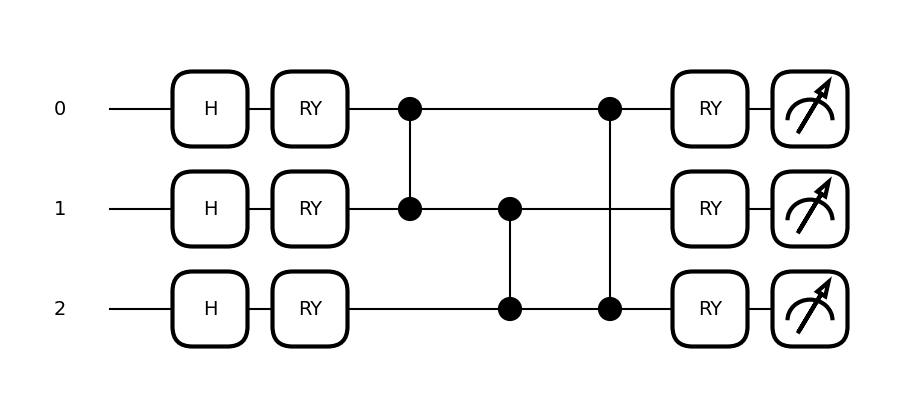

In [13]:
# Creating the quantum generator
import pennylane as qml

layers=1
qubits=data_dim
params=[np.random.uniform(np.pi) for i in range(qubits + layers*qubits)]
print(params)

device=qml.device('lightning.gpu',wires=qubits)
# device=qml.device('default.qubit',wires=qubits)

def generator(weights,wires,repetitions):
    for i in range(wires):
        qml.Hadamard(i)

    k=0

    for i in range(wires):
        qml.RY(weights[k],wires=i)
        k+=1

    for _ in range(repetitions):
        # Entangling blocks
        for i in range(wires-1):
            qml.CZ(wires=[i,i+1])

        # Last CZ turning to zero
        qml.CZ(wires=[wires-1,0])

    # RY rotations
    for i in range(wires):
        qml.RY(weights[k],wires=i)
        k+=1

    return qml.probs(wires=range(wires))

# Creating a QNode circuit wrapper
generator_circuit=qml.QNode(generator,device=device,interface='torch',diff_method='best')

# Drawing the circuit
circuit_viz=qml.draw_mpl(generator)
print(circuit_viz(params,qubits,layers))

In [14]:
# Creating the Discriminator
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        # Inheriting from the super class Module
        super(Discriminator, self).__init__()

        # Creating a fully-connected neural network layer from input_size consisting of 20 neurons
        self.linear=nn.Linear(input_size,20)

        # Creating an activation layer ReLU with negative slope(0.2)
        self.leaky_relu=nn.LeakyReLU(0.2)

        # From a fully-connected neural network layer bringing it down to 1 layer
        self.linear20=nn.Linear(20,1)

        # Creating a Sigmoid function in order to classify the data from the neural network as real or fake
        self.sigmoid=nn.Sigmoid()

    def forward(self, input: torch.Tensor)->torch.Tensor:
        x=self.linear(input)
        x=self.leaky_relu(x)
        x=self.linear20(x)
        x=self.sigmoid(x)
        return x

In [15]:
# Generator Loss Function
gen_loss=nn.BCELoss()

# Discriminator Loss Function
disc_loss=nn.BCELoss()

# GPU Configuration for Discriminator
device_gpu_config=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the discrmiminator
discriminator = Discriminator(input_size=1).to(device_gpu_config)


# Creating the hyperparameters
lr=0.001 # Learning Rate for the NN
b1=0.9 # First momentum parameter
b2=0.999 # Second momentum parameter
epochs=300 # Number of training iterations

# Creating the optimizer. We shall be using the Adam optimizer.
from torch.optim import Adam

# Optimizer for the generator function
generator_opt= qml.AdamOptimizer(stepsize=lr,beta1=b1,beta2=b2)

# Optimizer for the discriminator
discriminator_opt=Adam(discriminator.parameters(),lr=lr,betas=(b1,b2))

# Data Loader
from torch.utils.data import DataLoader

# Define the training batch size
batch_size=300

# Ensure data is a proper tensor
training_data = torch.tensor(training_data, dtype=torch.float32)

# Create DataLoader (drop incomplete batches)
data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)

# Lists for tracking losses for each epoch
gen_loss_epoch_values=[]
disc_loss_epoch_values=[]
generator_loss_values = []
discriminator_loss_values = []

# Index allocation probability wise
prob_dim=[]
index_allocation=0
for i in range(qubits):
  index_allocation+=qubits
  prob_dim.append(index_allocation)

print(prob_dim)

[3, 6, 9]


In [16]:
# Training Loop
for epoch in range(epochs):
    generator_loss_epoch = []
    discriminator_loss_epoch = []
    theta=torch.tensor(params,dtype=torch.float32)

    for i, data in enumerate(data_loader):
        data = data.to(device_gpu_config)

        # Create labels
        valid = torch.ones(data.size(0), 1, device=device_gpu_config)
        fake = torch.zeros(data.size(0), 1, device=device_gpu_config)

        # ----- Generate fake samples matching batch size -----
        fake_samples = []
        for _ in range(data.size(0)):  # not len(data_loader)!
            probs = generator_circuit(theta, qubits, layers)

            index_value=torch.argmax(probs)
            for i in range(len(prob_data)):
              if(index_value<prob_dim[i]):
                index_value=i

            generated_value = grid_elements[index_value]
            fake_samples.append(generated_value)

        # Convert to proper tensors
        real_inputs = data.view(-1, 1)
        fake_inputs = torch.tensor(fake_samples, dtype=torch.float32, device=device_gpu_config).view(-1, 1)

        # Forward passes
        real_outputs = discriminator(real_inputs)
        fake_outputs = discriminator(fake_inputs)

        # Discriminator loss
        real_loss = disc_loss(real_outputs, valid)
        fake_loss = disc_loss(fake_outputs, fake)
        discriminator_loss = (real_loss + fake_loss) / 2

        discriminator_opt.zero_grad()
        discriminator_loss.backward(retain_graph=True)
        discriminator_opt.step()

        # Generator training
        disc_outputs = discriminator(fake_inputs)
        generator_loss = gen_loss(disc_outputs, valid)
        returns, prev_cost = generator_opt.step_and_cost(generator_circuit, params, qubits, layers)
        params = returns[0]

        # Track losses
        generator_loss_epoch.append(generator_loss.item())
        discriminator_loss_epoch.append(discriminator_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] | Gen Loss: {np.mean(generator_loss_epoch):.4f} | Disc Loss: {np.mean(discriminator_loss_epoch):.4f}")

    gen_loss_epoch_values.append(np.mean(generator_loss_epoch))
    disc_loss_epoch_values.append(np.mean(discriminator_loss_epoch))


Epoch [1/300] | Gen Loss: 31.6146 | Disc Loss: 0.3803
Epoch [2/300] | Gen Loss: 13.1250 | Disc Loss: 0.3558
Epoch [3/300] | Gen Loss: 7.9833 | Disc Loss: 0.3361
Epoch [4/300] | Gen Loss: 7.5693 | Disc Loss: 0.3182
Epoch [5/300] | Gen Loss: 7.5932 | Disc Loss: 0.3008
Epoch [6/300] | Gen Loss: 7.6427 | Disc Loss: 0.2838
Epoch [7/300] | Gen Loss: 7.6772 | Disc Loss: 0.2674
Epoch [8/300] | Gen Loss: 7.9568 | Disc Loss: 0.2507
Epoch [9/300] | Gen Loss: 7.9963 | Disc Loss: 0.2324
Epoch [10/300] | Gen Loss: 8.0998 | Disc Loss: 0.2145
Epoch [11/300] | Gen Loss: 8.2016 | Disc Loss: 0.1972
Epoch [12/300] | Gen Loss: 8.2945 | Disc Loss: 0.1808
Epoch [13/300] | Gen Loss: 8.4166 | Disc Loss: 0.1653
Epoch [14/300] | Gen Loss: 8.5126 | Disc Loss: 0.1508
Epoch [15/300] | Gen Loss: 8.6287 | Disc Loss: 0.1375
Epoch [16/300] | Gen Loss: 8.7304 | Disc Loss: 0.1254
Epoch [17/300] | Gen Loss: 8.8447 | Disc Loss: 0.1142
Epoch [18/300] | Gen Loss: 8.9427 | Disc Loss: 0.1041
Epoch [19/300] | Gen Loss: 9.0555 |

In [17]:
samples=[]

for i in range(10):
  probs=generator_circuit(theta,qubits,layers)
  index_value=torch.argmax(probs)
  for i in range(len(prob_data)):
    if(index_value<prob_dim[i]):
      index_value=i
  generated_value=grid_elements[index_value]
  samples.append(generated_value)

print(probs)
print(grid_elements)
print(set(samples))

tensor([2.4761e-01, 5.2508e-02, 3.9811e-02, 5.8806e-07, 4.3209e-01, 1.1169e-01,
        1.1211e-01, 4.1796e-03], dtype=torch.float64)
[1398.4, 1448.8000000000002, 1499.2000000000003]
{1499.2000000000003}


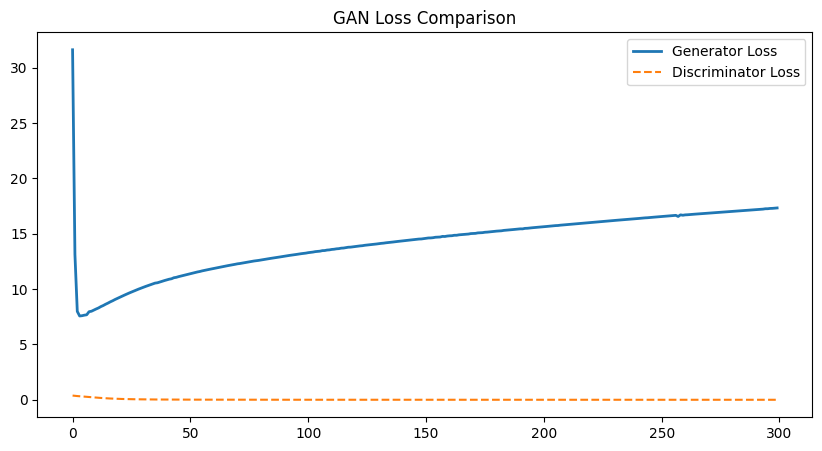

In [18]:
plt.figure(figsize=(10,5))
plt.plot(gen_loss_epoch_values, label="Generator Loss", linewidth=2)
plt.plot(disc_loss_epoch_values, label="Discriminator Loss", linestyle="--")
plt.legend()
plt.title("GAN Loss Comparison")
plt.show()